# Hypothesis - Device Activity

In [8]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

**Read Data**

In [9]:
# import data
data = pd.read_csv('../data/raw/raw_data.csv')
print(f"data shape: {data.shape}")
data.head()

data shape: (1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


## Data Cleaning

1. Deal with Missing Values
2. Deal with categorical and numerical data
3. Drop useless columns (`device_fraud_count`)

In [10]:
# missing values
# change all negative values to -1 for intended_balcon_amount
data['intended_balcon_amount'] = data['intended_balcon_amount'].apply(lambda x: -1 if x < 0 else x)

# for rows with values < 0 in 'current_address_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w', drop them
data = data[(data['current_address_months_count'] >= 0) & (data['session_length_in_minutes'] >= 0) & (data['device_distinct_emails_8w'] >= 0)]

In [11]:
# define categorical, change to 'category'
categorical_columns = ['fraud_bool', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'source', 'device_os', 'keep_alive_session']

# change datatype of categorical columns to 'category'
data[categorical_columns] = data[categorical_columns].astype('category')

# define numerical columns
numerical_columns = [col for col in data.columns if col not in categorical_columns]

# change datatype of categorical columns to 'category'
data[categorical_columns] = data[categorical_columns].astype('category')

In [12]:
# drop columns
columns_to_drop = ['velocity_4w', 'device_fraud_count']
data = data.drop(columns=columns_to_drop)

In [13]:
# check shape and head of data
print(f"data shape: {data.shape}")
data.head()

data shape: (993607, 30)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0
1,0,0.8,0.617426,-1,89,20,0.010095,-1.000000,AD,1658,...,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.000000,AB,1095,...,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.000000,AB,3483,...,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,26,0,200.0,0,INTERNET,3.743048,other,0,1,0


## Undersample data ratio 1:5

In [14]:
# undersample data 1:5
data_fraud = data[data['fraud_bool'] == 1]
data_non_fraud = data[data['fraud_bool'] == 0].sample(n=len(data_fraud)*5, random_state=42)

# combine data & shuffle
data = pd.concat([data_fraud, data_non_fraud])
data = data.sample(frac=1, random_state=42)

# check data
print(f'data shape: {data.shape}')
data.head()

data shape: (65970, 30)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
494176,0,0.3,0.344753,-1,67,40,0.000238,-1.000000,AB,839,...,15,0,500.0,0,INTERNET,16.588092,windows,0,1,3
856641,0,0.9,0.194198,-1,158,40,0.023728,-1.000000,AB,718,...,1,1,500.0,0,INTERNET,2.526773,windows,0,1,6
504979,0,0.9,0.092385,-1,31,20,0.031130,32.561138,AD,951,...,28,0,1500.0,0,INTERNET,4.054177,windows,1,1,3
538315,1,0.9,0.708968,-1,50,50,0.034457,-1.000000,AD,1746,...,1,0,200.0,0,INTERNET,6.909834,windows,0,1,3
709823,0,0.3,0.425083,111,12,20,8.986623,-1.000000,AC,2237,...,-1,0,200.0,0,INTERNET,11.278056,linux,1,1,5


## EDA Bank Activity and Device Activity

**Hypothesis: Fraudulent Bank Accounts have unique characteristics in relation to how their device activity.**
* More likely to use a phone that has more lax security i.e. windows
* More likely to have more than 1 email in each device. --> more emails to create more fake accounts
* If a phone has more than 1 email from each device, then it keep_alive_session likely to be false (i.e. value=0) --> convienience on fraudster's end. troublesome to log in and out continually.
* Session length will also be short??

**Columns considered**

* Device Activity:
    * `session_length_in_minutes`
    * `device_os`
    * `keep_alive_session`
    * `device_distinct_emails_8w`
    * `source`
    * `foreign_request`

* Bank Activity:
    * `zip_count_4w`
    * `velocity_6h`
    * `velocity_24h`
    * `velocity_4w`
    * `bank_branch_count_8w`
    * `date_of_birth_distinct_emails_4w`


In [15]:
# select columns related to device activity
device_activity  = ['fraud_bool', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'source', 'foreign_request']
device_activity_df = data[device_activity]

# print shape
device_activity_df.shape
device_activity_df.head()

,fraud_bool,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,source,foreign_request
494176,0,16.588092,windows,0,1,INTERNET,0
856641,0,2.526773,windows,0,1,INTERNET,0
504979,0,4.054177,windows,1,1,INTERNET,0
538315,1,6.909834,windows,0,1,INTERNET,0
709823,0,11.278056,linux,1,1,INTERNET,0


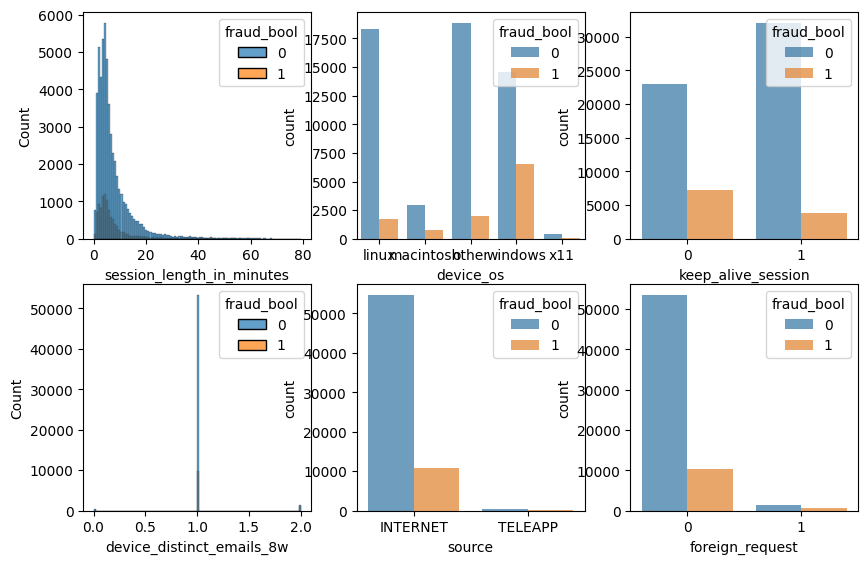

In [16]:
# for each column, if it is categorical, plot the value counts, if it is numerical, plot histogram
# put in a 3 x 3 grid, and color code the fraud_bool column
# print all except the first column
plt.figure(figsize=(10, 10))
for i, col in enumerate(device_activity_df.columns[1:]):
    plt.subplot(3, 3, i+1)
    if device_activity_df[col].dtype.name == 'category':
        sns.countplot(data=device_activity_df, x=col, hue='fraud_bool', alpha=0.7)
    else:
        sns.histplot(data=device_activity_df, x=col, hue='fraud_bool', bins=100, alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os        x11  0.171247   0.828753
0                  device_os  macintosh  0.204076   0.795924
0         keep_alive_session          0  0.239448   0.760552
0         keep_alive_session          1  0.105193   0.894807
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258


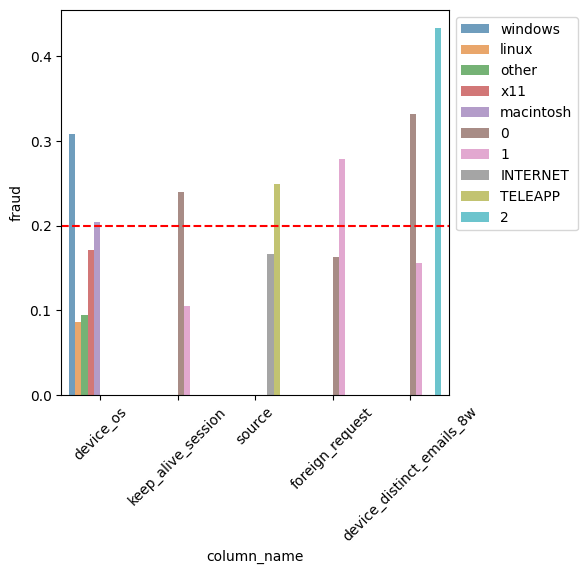

In [27]:
# chance device_distinct_emails_8w to category
device_activity_df['device_distinct_emails_8w'] = device_activity_df['device_distinct_emails_8w'].astype('category')

# check proportion of fraud vs non-fraud within each category
categorical_columns = ['fraud_bool', 'device_os', 'keep_alive_session', 'source', 'foreign_request', 'device_distinct_emails_8w']
device_activity_df_cat = device_activity_df[categorical_columns]

# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### `device_distinct_emails` == 0 or 2 & `device_os` == windows, featureEng01 == 1, else 0

<Axes: xlabel='featureEng01', ylabel='count'>

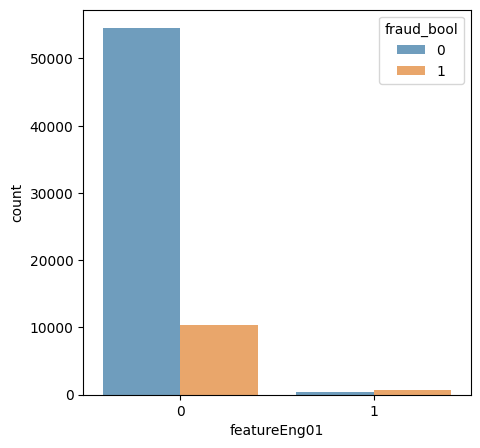

In [35]:
# label columns with the following conditions met as a new column, 'featureEng01'
# if conditions met, label as 1, else 0
# 1. device_os is 'windows'
# 2. device_distinct_emails_8w is 0 or 2
device_activity_df_cat['featureEng01'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_os'] == 'windows') & (device_activity_df_cat['device_distinct_emails_8w'].isin([0, 2])), 'featureEng01'] = 1

# change 'featureEng01' to category
device_activity_df_cat['featureEng01'] = device_activity_df_cat['featureEng01'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng01', hue='fraud_bool', alpha=0.7)




                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os        x11  0.171247   0.828753
0                  device_os  macintosh  0.204076   0.795924
0         keep_alive_session          0  0.239448   0.760552
0         keep_alive_session          1  0.105193   0.894807
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

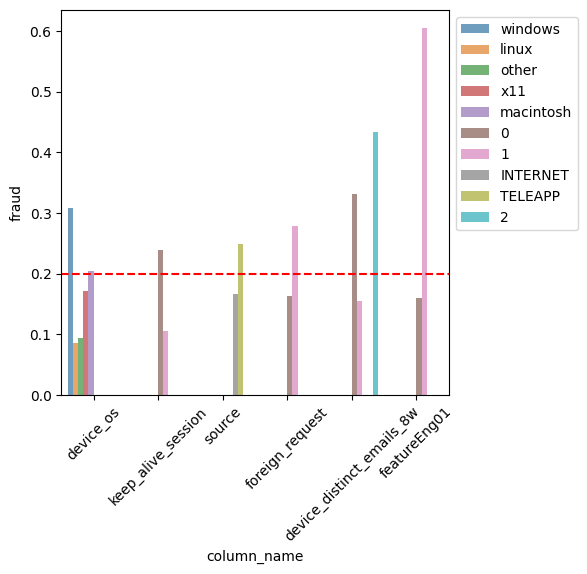

In [36]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### `device_distinct_emails_8w` == 2 & `keep_alive_session` == 0, featureEng02 == 1, else 0

<Axes: xlabel='featureEng02', ylabel='count'>

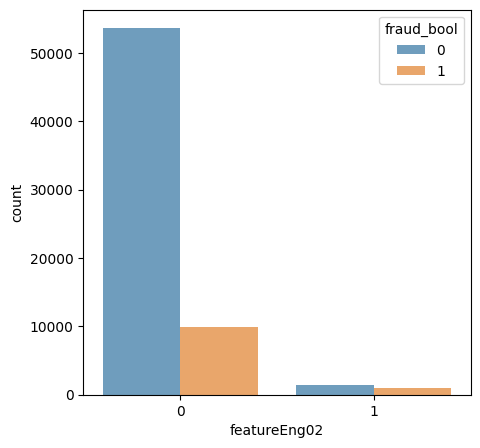

In [38]:
# label columns with the following conditions met as a new column, 'featureEng02'
# if conditions met, label as 1, else 0
# 1. device_distinct_emails_8w is 2
# 2. keep_alive_session is '0'
device_activity_df_cat['featureEng02'] = 0
device_activity_df_cat.loc[(device_activity_df_cat['device_distinct_emails_8w'] == 2) | (device_activity_df_cat['keep_alive_session'] == '0'), 'featureEng02'] = 1

# change 'featureEng02' to category
device_activity_df_cat['featureEng02'] = device_activity_df_cat['featureEng02'].astype('category')

# plot the proportion of fraud vs non-fraud for the new column 'featureEng01'
# fraud is in red, non-fraud is in blue
# y axis is the count
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.countplot(data=device_activity_df_cat, x='featureEng02', hue='fraud_bool', alpha=0.7)

                 column_name   category     fraud  non_fraud
0                  device_os    windows  0.308299   0.691701
0                  device_os      linux  0.085653   0.914347
0                  device_os      other  0.094239   0.905761
0                  device_os        x11  0.171247   0.828753
0                  device_os  macintosh  0.204076   0.795924
0         keep_alive_session          0  0.239448   0.760552
0         keep_alive_session          1  0.105193   0.894807
0                     source   INTERNET  0.166179   0.833821
0                     source    TELEAPP  0.248718   0.751282
0            foreign_request          0  0.163176   0.836824
0            foreign_request          1  0.278894   0.721106
0  device_distinct_emails_8w          1  0.155487   0.844513
0  device_distinct_emails_8w          2  0.433417   0.566583
0  device_distinct_emails_8w          0  0.331742   0.668258
0               featureEng01          0  0.158957   0.841043
0               featureE

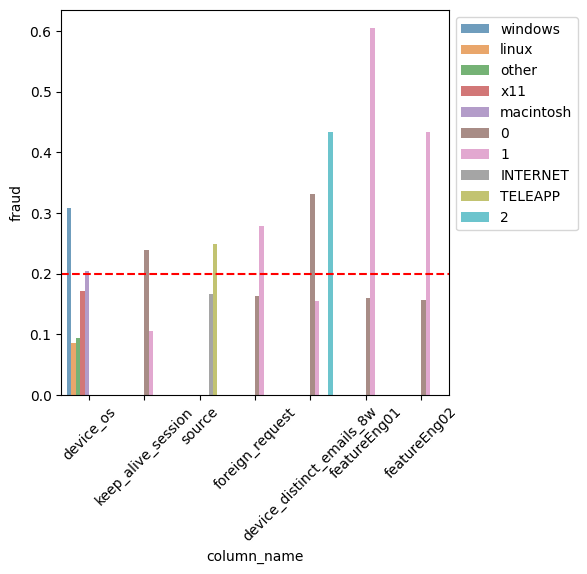

In [39]:
# reprint fraud proportion
# caluclate proportion of fraud vs non-fraud for each category
# for each column, calculate the proportion of fraud vs non-fraud, store in dataframe
# there are 4 columns, 'column_name', 'category', 'fraud', 'non_fraud'
fraud_proportion = pd.DataFrame(columns=['column_name', 'category', 'fraud', 'non_fraud'])
for col in device_activity_df_cat.columns[1:]:
    for cat in device_activity_df_cat[col].unique():
        fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 1)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])
        non_fraud = len(device_activity_df_cat[(device_activity_df_cat[col] == cat) & (device_activity_df_cat['fraud_bool'] == 0)]) / len(device_activity_df_cat[device_activity_df_cat[col] == cat])

        # add to dataframe using pd.concat to row
        fraud_proportion = pd.concat([fraud_proportion, pd.DataFrame({'column_name': [col], 'category': [cat], 'fraud': [fraud], 'non_fraud': [non_fraud]})])

# print table
print(fraud_proportion)

# a stacked barplot the proportion of fraud vs non-fraud for each category
# each column is labeled column_name + _ + category
# fraud is in red, non-fraud is in blue
# the y-axis is the proportion
# x-axis tilt by 45 degrees
plt.figure(figsize=(5, 5))
sns.barplot(data=fraud_proportion, x='column_name', y='fraud', hue='category', alpha=0.7)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xticks(rotation=45)
# legend is outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
# plot the 

**Hypothesis: Fraudulent Bank Accounts have unique characteristics in relation to how their device activity.**

* More likely to use a phone that has more lax security i.e. windows
* More likely to have more than 1 email in each device. --> more emails to create more fake accounts
* If a phone has more than 1 email from each device, then it keep_alive_session likely to be false (i.e. value=0) --> convienience on fraudster's end. troublesome to log in and out continually.
* Session length will also be short??


**Insights**

1. 

In [ ]:
# split session_length_in_minutes into 2 groups, fraud and non-fraud
session_length_fraud = device_activity_df[device_activity_df['fraud_bool'] == 1][['session_length_in_minutes', 'fraud_bool']]
sessions_length_non_fraud = device_activity_df[device_activity_df['fraud_bool'] == 0][['session_length_in_minutes', 'fraud_bool']]

# print shapes
print(f"fraud shape: {session_length_fraud.shape}")
print(f"non-fraud shape: {sessions_length_non_fraud.shape}")

In [ ]:
# plot boxplot for non-fraud session length in minutes
# plot side by side, with different colors, on columns 'session_length_in_minutes'
plt.figure(figsize=(6, 3))
sns.boxplot(data=session_length_fraud, x='session_length_in_minutes', color='red')

In [ ]:
# plot boxplot for non-fraud session length in minutes
plt.figure(figsize=(6, 3))
sns.boxplot(data=sessions_length_non_fraud, x='session_length_in_minutes', color='blue')

In [ ]:
device_activity_df.columns

In [ ]:
# select columns related to device activity
device_activity  = ['fraud_bool', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'source', 'foreign_request']
device_activity_df = data[device_activity]

In [ ]:
# check value_counts for device_distinct_emails_8w
device_activity_df['device_distinct_emails_8w'].value_counts()

In [ ]:
# select device_distinct_emails_8w and fraud_bool columns, and select all the frauds
device_distinct_emails_fraud = device_activity_df[device_activity_df['fraud_bool'] == 1][['device_distinct_emails_8w', 'fraud_bool']]
device_distinct_emails_non_fraud = device_activity_df[device_activity_df['fraud_bool'] == 0][['device_distinct_emails_8w', 'fraud_bool']]

# plot count plot for both fraud and non-fraud, in 1 x 2 grid, provide title for each
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=device_distinct_emails_fraud, x='device_distinct_emails_8w', hue='fraud_bool')
plt.title('Fraud')
plt.subplot(1, 2, 2)
sns.countplot(data=device_distinct_emails_non_fraud, x='device_distinct_emails_8w', hue='fraud_bool')
plt.title('Non-Fraud')


In [ ]:
# use the device_activity_df, combine the device_os and keep_alive_sessions columns
# change device_os and keep_alive_session to str
device_activity_df['device_os'] = device_activity_df['device_os'].astype(str)
device_activity_df['keep_alive_session'] = device_activity_df['keep_alive_session'].astype(str)
device_activity_df['device_os_keep_alive'] = device_activity_df['device_os'] + '_' + device_activity_df['keep_alive_session']

# plot countplot for device_os_keep_alive
plt.figure(figsize=(12, 6))
sns.countplot(data=device_activity_df, x='device_os_keep_alive', hue='fraud_bool')

In [ ]:
# convert device_activity_df['fraud_bool'] to 1 and 0
device_activity_df['fraud_bool'] = device_activity_df['fraud_bool'].astype(int)

# group by device_os_keep_alive
# within each group, find the 2 proportions - proportion of frauds, i.e. number of fraud/total, and proportion of non-frauds, i.e. number of non-frauds/total
device_os_keep_alive_grouped = device_activity_df.groupby('device_os_keep_alive')

# iterate through each group, create a dataframe where the row corresponds to the group, and the columns are 'fraud_proportion' and 'non_fraud_proportion'
fraud_proportion = []
non_fraud_proportion = []
for name, group in device_os_keep_alive_grouped:
    fraud_proportion.append(group['fraud_bool'].sum()/len(group))
    non_fraud_proportion.append((len(group) - group['fraud_bool'].sum())/len(group))

# create a dataframe
fraud_non_fraud_proportion_df = pd.DataFrame({'device_os_keep_alive': device_os_keep_alive_grouped.groups.keys(), 'fraud_proportion': fraud_proportion, 'non_fraud_proportion': non_fraud_proportion})
fraud_non_fraud_proportion_df.head()

# plot in such that it is a barplot, but the bars are stacked
plt.figure(figsize=(12, 6))
plt.bar(fraud_non_fraud_proportion_df['device_os_keep_alive'], fraud_non_fraud_proportion_df['non_fraud_proportion'], bottom=fraud_non_fraud_proportion_df['fraud_proportion'], label='non-fraud')
plt.bar(fraud_non_fraud_proportion_df['device_os_keep_alive'], fraud_non_fraud_proportion_df['fraud_proportion'], label='fraud')
plt.legend()


In [ ]:
device_activity_df.head()

In [ ]:
device_activity_df.dtypes

In [ ]:
# values count for distinct_emails_8w
device_activity_df['device_distinct_emails_8w'].value_counts()

# group by device_distinct_emails_8w
# within each group, find the 2 proportions - proportion of frauds, i.e. number of fraud/total, and proportion of non-frauds, i.e. number of non-frauds/total
device_distinct_emails_grouped = device_activity_df.groupby('device_distinct_emails_8w')

# iterate through each group, create a dataframe where the row corresponds to the group, and the columns are 'fraud_proportion' and 'non_fraud_proportion'
fraud_proportion = []
non_fraud_proportion = []
for name, group in device_distinct_emails_grouped:
    fraud_proportion.append(group['fraud_bool'].sum()/len(group))
    non_fraud_proportion.append((len(group) - group['fraud_bool'].sum())/len(group))

# create a dataframe
fraud_non_fraud_proportion_df = pd.DataFrame({'device_distinct_emails_8w': device_distinct_emails_grouped.groups.keys(), 'fraud_proportion': fraud_proportion, 'non_fraud_proportion': non_fraud_proportion})
fraud_non_fraud_proportion_df.head()

# plot in such that it is a barplot, but the bars are stacked
plt.figure(figsize=(12, 6))
plt.bar(fraud_non_fraud_proportion_df['device_distinct_emails_8w'], fraud_non_fraud_proportion_df['non_fraud_proportion'], bottom=fraud_non_fraud_proportion_df['fraud_proportion'], label='non-fraud')
plt.bar(fraud_non_fraud_proportion_df['device_distinct_emails_8w'], fraud_non_fraud_proportion_df['fraud_proportion'], label='fraud')
plt.legend()

In [ ]:
# re read device_activity_df
device_activity_df = data[device_activity]
device_activity_df.dtypes